# Collaborative filtering

This notebook builds a collaborative filtering model to be applied to Hybrid movie recommender systems.

In [1]:
import numpy as np
import pandas as pd
import random
from time import time
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from surprise import Reader, Dataset, SVD, evaluate, accuracy, dump
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

## 1. Load and prepare data

### 1.1. Load data with pandas

For the scope of this project, we use `ratings_small.csv`, which contains a fraction of all the rating data. Smaller data size enables faster training and prediction.

In [2]:
# Load the raw data with pandas
df = pd.read_csv("Data/ratings_small.csv")
df.head()

,userId,movieId,rating,timestamp
0,74275,110,3.5,1353192383
1,78317,110,4.0,1486392096
2,261638,147,4.5,1277404478
3,107815,147,4.0,888507963
4,166249,147,3.5,1464472631


### 1.2. Check for duplicates

Check whether a user has rated the movie twice, in which case the latest rating will be kept and the duplicates will be removed.

In [3]:
# Group by userId, movieId to see if there are multiple rating by a user for a given movie
db_grouped = df[['userId', 'movieId','rating']].groupby(['userId','movieId']).count()

# Sort decending show show any multiple ratings.
db_grouped.sort_values(by='rating', ascending=False).head()

rating
userId movieId        
229    77            1
179161 4986          1
179259 5146          1
       4958          1
       4710          1

There is no dulicate ratings by the same user.

### 1.3. Data exploration

In [4]:
# Total number of records
n_records = df.shape[0]

# Total number of movies
n_movies = df['movieId'].nunique()

# Total number of users
n_users = df['userId'].nunique()

# Print the results
print("Total number of records: {}".format(n_records))
print("Total number of movies: {}".format(n_movies))
print("Total number of users: {}".format(n_users))

Total number of records: 122063
Total number of movies: 7407
Total number of users: 2276


Text(0,0.5,'Number of Records')

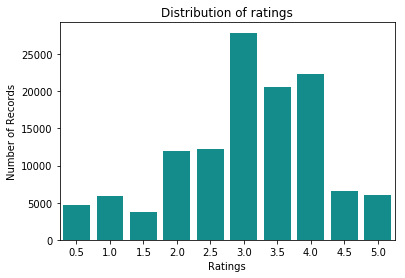

In [5]:
# Distribution of ratings
# plt.hist(df['rating'], bins = 10, color = '#00A0A0', align='mid')
# sns.distplot(df['rating'], kde=False)
sns.countplot(x='rating', data=df, color='#00A0A0')
plt.title("Distribution of ratings")
plt.xlabel('Ratings')
plt.ylabel("Number of Records")

### 1.4. Load data with surprise

In [6]:
# Load the full dataset with `surprise`
reader = Reader()
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
raw_ratings = data.raw_ratings

### 1.5. Shuffle and Split Data

Split the data into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Shuffle ratings
random.shuffle(raw_ratings)

# Split dataset into training (A) and testing (B) sets
# A = 80% of the data, B = 20% of the data
train_size = 0.8
threshold = int(train_size * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [8]:
len(A_raw_ratings)

97650

## 2. Evaluate model performance

### 2.1. Naive predictor

The purpose of generating a "naive predictor" is simply to show what a base model without any intelligence would look like, to help establish a benchmark for whether a machine learning model is performing better than random guesses. Here we use uniformly-distributed random prediction between 0 and 5 as the naive predictor of user-specific movie ratings.

In [9]:
ratings_pred = df['rating'].apply(lambda x: random.uniform(0, 5))
ratings_actual = df['rating']

Root mean squared error (RMSE) is chosen to be the model evaluation metric. RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

$RMSE=\sqrt{\frac{1}{n}\sum_{j=1}^n(y_j-\hat{y_j})^2}$

RMSE expresses model prediction error, which can range from 0 to ∞ and is indifferent to the direction of errors. RMSE is negatively-oriented score, which means lower values are better.

Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. In other words, RMSE has the benefit of penalizing large errors more, which is appropriate in our case because large mismatch of user's preference is strongly undesirable. ([check out here for a comparison between RMSE and MAE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d))

In [10]:
# RMSE of naive predictor
naive_rmse = sqrt(mean_squared_error(ratings_actual, ratings_pred))
print(f"RMSE of naive predictor: {naive_rmse}")

RMSE of naive predictor: 1.8858525296083417


### 2.2. Singular value decomposition (SVD) model for collaborative filtering

- [Link to documentation](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)
- [A blog post explaining the algorithm](https://beckernick.github.io/matrix-factorization-recommender/)

### 2.3. Initial evaluation of model performance on various sizes of training data

Create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

- Fit the learner to the sampled training data and record the training time.
- Perform predictions on the test data and on the training data.
- Record the total prediction time.
- Calculate the RMSE score for both the training set and testing set.

In [11]:
def train_predict(algo, sample_size, A_raw_ratings, data): 
    '''
    inputs:
       - algo: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - A_raw_ratings: training set
       - data: surprise dataset
    '''
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    data.raw_ratings = A_raw_ratings[:sample_size] # Data is now the set A
    
    # Run 5-fold cross-validation and print results
    results = cross_validate(algo, data, measures=['RMSE'], return_train_measures=True, cv=3, verbose=True)
    
    print(results)
       
    # Success
    print("\nSVD trained on {} samples.\n---".format(sample_size))
        
    # Return the results
    return results

In [12]:
# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set
# samples_10 is 10% of samples_100
# samples_1 is 1% of samples_100

# Sample percentages of the training data, [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pctgs = list(range(10, 101, 10))
pctgs.insert(0, 1)

# Full sample size
sample_size_full = len(A_raw_ratings)

# Use SVD model
algo = SVD()

# Collect results on the learners
results = []

for pctg in pctgs:
    sample_size = int(sample_size_full * pctg / 100)
    result = train_predict(algo, sample_size, A_raw_ratings, data)
    results.append(result)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0632  1.0517  1.0883  1.0678  0.0153  
RMSE (trainset)   0.7067  0.7169  0.7053  0.7096  0.0051  
Fit time          0.07    0.06    0.05    0.06    0.01    
Test time         0.01    0.00    0.00    0.00    0.00    
{'test_rmse': array([1.06320561, 1.05174834, 1.0883265 ]), 'train_rmse': array([0.70672273, 0.71688126, 0.70533363]), 'fit_time': (0.06784415245056152, 0.06185293197631836, 0.050401926040649414), 'test_time': (0.0076029300689697266, 0.002748250961303711, 0.0024390220642089844)}

SVD trained on 976 samples.
---
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9978  0.9856  0.9950  0.9928  0.0052  
RMSE (trainset)   0.6693  0.6735  0.6742  0.6723  0.0022  
Fit time          0.55    0.51    0.48    0.51    0.03    
Test time         0.03    0.02    0.02    0.03    0.00    


Text(0.5,1,'Training RMSE vs validation RMSE')

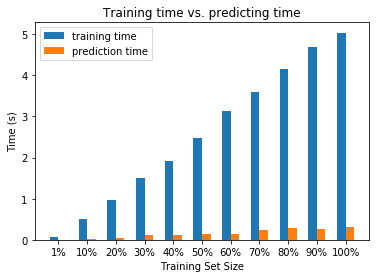

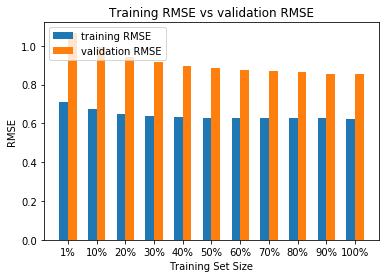

In [13]:
# Visualize performance metrics
x = range(len(pctgs))
train_time = [np.mean(result['fit_time']) for result in results]
pred_time = [np.mean(result['test_time']) for result in results]
rmse_train = [np.mean(result['train_rmse']) for result in results]
rmse_test = [np.mean(result['test_rmse']) for result in results]
bar_width = 0.3

plt.figure()
plt.bar(x, train_time, width=bar_width)
plt.bar([a+bar_width for a in x], pred_time, width=bar_width)
plt.xticks([a+bar_width/2 for a in x], [f"{pctg}%" for pctg in pctgs])
plt.xlabel("Training Set Size")
plt.ylabel('Time (s)')
plt.legend(['training time', 'prediction time'])
plt.title('Training time vs. predicting time')
# plt.savefig(f'Figures/initial_model_eval_time.png', bbox_inches="tight", dpi = 300)

plt.figure()
plt.bar(x, rmse_train, width=bar_width)
plt.bar([a+bar_width for a in x], rmse_test, width=bar_width)
plt.xticks([a+bar_width/2 for a in x], [f"{pctg}%" for pctg in pctgs])
plt.xlabel("Training Set Size")
plt.ylabel('RMSE')
plt.legend(['training RMSE', 'validation RMSE'], loc='upper left')
plt.title('Training RMSE vs validation RMSE')
# plt.savefig(f'Figures/initial_model_eval_rmse.png', bbox_inches="tight", dpi = 300)

The second graph above suggests high variance of the model, i.e., the model overfits on the training set and thus cannot generalize well on the validation set. Therefore, the strategy to optimize the model is to use the full set of data, and to increase regularization term (which penalizes large parameters). For faster training, we decided to keep the number of epochs of stochastic gradient descent to be the default value 20. Model optimization is detailed in the following section.

## 3. Tune the model

Perform a grid search optimization for the SVD model over the entire training set by tuning hyperparameters to improve RMSE score.
https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation

In [14]:
# Data is now the set A
data.raw_ratings = A_raw_ratings

# Tune hyperparameters with grid search
print('Grid Search...')
param_grid = {
    'n_factors': [50, 100, 200, 500], # default is 100
    'n_epochs': [20], # default is 20
    'lr_all': [0.005, 0.01, 0.1], # default is 0.005
    'reg_all': [0.02, 0.1, 1] # default is 0.02
}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=2, joblib_verbose=0)
grid_search.fit(data)

# Best RMSE score
print(f"Best RMSE score: \n{grid_search.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(f"Best parameters: \n{grid_search.best_params['rmse']}")

Grid Search...
Best RMSE score: 
0.8415860855951056
Best parameters: 
{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


In [15]:
# Save tuned model parameters
best_params = grid_search.best_params['rmse']

with open('cf_params.pickle', 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Final model evaluation

Evaluate model performance on test set

### 4.1. Model performance on various sizes of training data

In [16]:
# Select the algorithm with the best performance
algo = grid_search.best_estimator['rmse']

In [17]:
# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set
# samples_10 is 10% of samples_100
# samples_1 is 1% of samples_100

# Sample percentages of the training data, [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pctgs = list(range(10, 101, 10))
pctgs.insert(0, 1)

# Full sample size
sample_size_full = len(A_raw_ratings)

# Collect results on the learners
results = []

for pctg in pctgs:
    sample_size = int(sample_size_full * pctg / 100)
    result = train_predict(algo, sample_size, A_raw_ratings, data)
    results.append(result)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0087  1.0295  1.1277  1.0553  0.0519  
RMSE (trainset)   0.5939  0.5881  0.5690  0.5837  0.0106  
Fit time          0.04    0.03    0.03    0.03    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    
{'test_rmse': array([1.00871431, 1.02946234, 1.1277047 ]), 'train_rmse': array([0.59389699, 0.58808163, 0.5689729 ]), 'fit_time': (0.037364959716796875, 0.034718990325927734, 0.0328218936920166), 'test_time': (0.0028281211853027344, 0.002683877944946289, 0.002542734146118164)}

SVD trained on 976 samples.
---
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9817  0.9619  0.9682  0.9706  0.0083  
RMSE (trainset)   0.5804  0.5864  0.5868  0.5845  0.0029  
Fit time          0.34    0.34    0.37    0.35    0.01    
Test time         0.03    0.03    0.03    0.03    0.00    
{

Text(0.5,1,'Training RMSE vs validation RMSE')

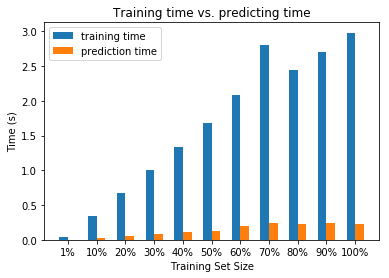

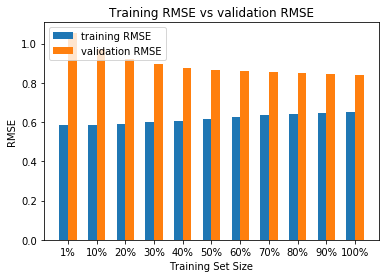

In [18]:
# Visualize performance metrics
x = range(len(pctgs))
train_time = [np.mean(result['fit_time']) for result in results]
pred_time = [np.mean(result['test_time']) for result in results]
rmse_train = [np.mean(result['train_rmse']) for result in results]
rmse_test = [np.mean(result['test_rmse']) for result in results]
bar_width = 0.3

plt.figure()
plt.bar(x, train_time, width=bar_width)
plt.bar([a+bar_width for a in x], pred_time, width=bar_width)
plt.xticks([a+bar_width/2 for a in x], [f"{pctg}%" for pctg in pctgs])
plt.xlabel("Training Set Size")
plt.ylabel('Time (s)')
plt.legend(['training time', 'prediction time'])
plt.title('Training time vs. predicting time')
# plt.savefig(f'Figures/initial_model_eval_time.png', bbox_inches="tight", dpi = 300)

plt.figure()
plt.bar(x, rmse_train, width=bar_width)
plt.bar([a+bar_width for a in x], rmse_test, width=bar_width)
plt.xticks([a+bar_width/2 for a in x], [f"{pctg}%" for pctg in pctgs])
plt.xlabel("Training Set Size")
plt.ylabel('RMSE')
plt.legend(['training RMSE', 'validation RMSE'], loc='upper left')
plt.title('Training RMSE vs validation RMSE')
# plt.savefig(f'Figures/initial_model_eval_rmse.png', bbox_inches="tight", dpi = 300)

In [19]:
# def learning_curve(algo):

#     # Sample percentages of the training data, [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#     pctgs = list(range(10, 101, 10))
#     pctgs.insert(0, 1)

#     # Full sample size
#     sample_size_full = len(A_raw_ratings)

#     # Collect results on the learners
#     results = []

#     for pctg in pctgs:
#         sample_size = int(sample_size_full * pctg / 100)
#         result = train_predict(algo, sample_size, A_raw_ratings, data)
#         results.append(result)

#     # Visualize performance metrics
#     x = range(len(pctgs))
#     train_time = [np.mean(result['fit_time']) for result in results]
#     pred_time = [np.mean(result['test_time']) for result in results]
#     rmse_train = [np.mean(result['train_rmse']) for result in results]
#     rmse_test = [np.mean(result['test_rmse']) for result in results]
#     bar_width = 0.3

#     plt.figure()
#     plt.bar(x, train_time, width=bar_width)
#     plt.bar([a+bar_width for a in x], pred_time, width=bar_width)
#     plt.xticks([a+bar_width/2 for a in x], [f"{pctg}%" for pctg in pctgs])
#     plt.xlabel("Training Set Size")
#     plt.ylabel('Time (s)')
#     plt.legend(['training time', 'prediction time'])
#     plt.title('Training time vs. predicting time')
#     # plt.savefig(f'Figures/initial_model_eval_time.png', bbox_inches="tight", dpi = 300)

#     plt.figure()
#     plt.bar(x, rmse_train, width=bar_width)
#     plt.bar([a+bar_width for a in x], rmse_test, width=bar_width)
#     plt.xticks([a+bar_width/2 for a in x], [f"{pctg}%" for pctg in pctgs])
#     plt.xlabel("Training Set Size")
#     plt.ylabel('RMSE')
#     plt.legend(['training RMSE', 'validation RMSE'], loc='upper left')
#     plt.title('Training RMSE vs validation RMSE')
#     # plt.savefig(f'Figures/initial_model_eval_rmse.png', bbox_inches="tight", dpi = 300)

In [20]:
# algo = SVD(
#     n_factors = 50, 
#     n_epochs = 200, 
#     lr_all = 0.01, 
#     reg_all = 0.1
# )

# learning_curve(algo)

### 4.2. Model performance on testing set

In [21]:
# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions_train = algo.test(trainset.build_testset())
print('Training RMSE score (Set A),', end='   ')
rmse_train_best = accuracy.rmse(predictions_train)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_test = algo.test(testset)
print('Testing RMSE score (Set B),', end='    ')
rmse_test_best = accuracy.rmse(predictions_test)

Training RMSE score (Set A),   RMSE: 0.6696
Testing RMSE score (Set B),    RMSE: 0.8305


In [22]:
# Report the before-and-after scores
print("Naive predictor:")
print("RMSE of naive predictor: {:.4f}".format(naive_rmse))
print("\nUnoptimized model:")
print("RMSE score on testing data: {:.4f}".format(rmse_test[-1]))
print("\nOptimized Model:")
print("Final RMSE score on the testing data: {:.4f}".format(rmse_test_best))

Naive predictor:
RMSE of naive predictor: 1.8859

Unoptimized model:
RMSE score on testing data: 0.8419

Optimized Model:
Final RMSE score on the testing data: 0.8305


## 5. Predict user-specific ratings

In [23]:
# # Load the full dataset with `surprise`
# reader = Reader()
# data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# # Than predict ratings for all pairs (u, i) that are NOT in the training set
# trainset = data.build_full_trainset()
# testset = trainset.build_anti_testset()
# predictions = algo.test(testset)

In [24]:
# Get the unique movie ids from the ratings data
movie_ids = list(np.sort(df['movieId'].unique()))
df_pred = pd.DataFrame({'movieID': movie_ids})

# Predict user-specific ratings for all the movie ids in the ratings data
user_id = 1
df_pred['rating_cf_pred'] = df_pred['movieID'].apply(lambda x: algo.predict(user_id, x).est)
df_pred.head()

,movieID,rating_cf_pred
0,2,2.944047
1,3,2.862642
2,5,2.691663
3,6,3.410280
4,11,3.378994


## 6. Write training and predicting into functions for continuous learning

Objectives: 

- Train the model using the tuned SVD parameters whenever new data of user rating feed in.
- Predict user-specific ratings based on up-to-date model

The resulting functions are written in `cf_train_predict.py`[cf_train_predict.py]

In [25]:
# Load tuned SVD parameters
with open('cf_params.pickle', 'rb') as handle:
    best_params = pickle.load(handle)

best_params

{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}

#### Training

- Input: updated ratings dataframe from the user interface
- Output: SVD model retrained using the optimized hyperparameters

In [26]:
# Load the full dataset from dataframe
reader = Reader()
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Train SVD model using tuned parameters
algo = SVD(
    n_epochs = best_params['n_epochs'],
    lr_all = best_params['lr_all'],
    reg_all = best_params['reg_all'],
)
trainset = data.build_full_trainset()
algo.fit(trainset)

# # Compute predictions of the 'original' algorithm.
# predictions = algo.test(trainset.build_testset())

# Dump algorithm
dump.dump('cf_model', algo=algo)

In [27]:
# _, loaded_algo = dump.load('cf_model')

# # We now ensure that the algo is still the same by checking the predictions.
# predictions_loaded_algo = loaded_algo.test(trainset.build_testset())
# assert predictions == predictions_loaded_algo
# print('Predictions are the same')

#### Save movie metadata for later use

In [28]:
# Save movies metadata for all movies
df_meta = pd.read_csv("Data/movies_Merged_Alldata.csv.gz")
df_meta = df_meta[['id', 'title', 'original_language', 'poster_path', 'release_date']]
df_meta = df_meta.drop_duplicates(subset=['id'])

# Full poster path
base_url = "http://image.tmdb.org/t/p/w185_and_h278_bestv2"
df_meta['poster_path_full'] = base_url + df_meta['poster_path']
df_meta = df_meta.drop(columns=['poster_path'])
df_meta = df_meta.fillna('')

# Save as reference df
df_meta.to_csv("cf_meta.csv.gz", index=False, compression="gzip")

#### Predicting

- Input: user id and most updated model
- Output: dataframe of movie ids and predicted ratings

In [29]:
# Load trained SVD model
_, algo = dump.load('cf_model')

# Get the unique movie ids from the ratings data
movie_ids = list(np.sort(df['movieId'].unique()))
df_pred = pd.DataFrame({'movieID': movie_ids})

# Predict user-specific ratings for all the movie ids in the ratings data
user_id = 1
df_pred['rating_cf_pred'] = df_pred['movieID'].apply(lambda x: algo.predict(user_id, x).est)

# Load reference movies metadata
df_meta = pd.read_csv("cf_meta.csv.gz")

# Merge predictions with metadata
df_pred = df_pred.merge(df_meta, how='inner', left_on='movieID', right_on='id')

# Sort by predicted rating
df_pred = df_pred.sort_values(by=['rating_cf_pred'], ascending=False)

# Drop duplicated movie id column
df_pred = df_pred.drop(columns=['id'])

# Fill NaN with ''
df_pred = df_pred.fillna('')
df_pred.head()

,movieID,rating_cf_pred,title,original_language,release_date,poster_path_full
809,1245,4.098349,The Remains of the Day,en,1993-11-05,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
3291,27033,4.086923,The Strange Love of Martha Ivers,en,1946-07-24,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
822,1260,4.052935,Lotte from Gadgetville,et,2006-08-25,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
2166,5147,4.045013,The Lost Continent,en,1968-06-19,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
4279,52767,4.041979,The Hunter,fa,2010-04-08,http://image.tmdb.org/t/p/w185_and_h278_bestv2...


#### Test written functions

In [30]:
from cf_train_predict import predict_cf

In [31]:
predict_cf(1)

,movieID,rating_cf_pred,title,original_language,release_date,poster_path_full
809,1245,4.098349,The Remains of the Day,en,1993-11-05,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
3291,27033,4.086923,The Strange Love of Martha Ivers,en,1946-07-24,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
822,1260,4.052935,Lotte from Gadgetville,et,2006-08-25,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
2166,5147,4.045013,The Lost Continent,en,1968-06-19,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
4279,52767,4.041979,The Hunter,fa,2010-04-08,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
73,111,4.030106,Scarface,en,1983-12-08,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
6743,142115,4.028242,Five Dances,en,2013-06-19,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
84,123,4.022133,The Lord of the Rings,en,1978-11-15,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
181,235,4.018106,Stand by Me,en,1986-08-22,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
4483,59387,3.972956,The Powerpuff Girls Movie,en,2002-07-03,http://image.tmdb.org/t/p/w185_and_h278_bestv2...
